In [1]:
import pandas as pd
from datetime import datetime
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [2]:
# this is to make it so that new files can be easily analyzed
data_load_start_date = '04-12-2020'
data_load_end_date = '02-02-2021'

# create date range and format it nicely
dates = pd.date_range(data_load_start_date, data_load_end_date)
dates.format(formatter=lambda x: x.strftime('%m-%d-%Y'))

date_list = []
# print all dates
for date in dates:
    current_date = date.strftime('%m-%d-%Y')
    #print(current_date)
    date_list.append(current_date)

print("Date list has been generated, first date: " + str(date_list[0]) + ", last date: " + str(date_list[-1]) + ", number of dates: " + str(len(date_list)))

Date list has been generated, first date: 04-12-2020, last date: 02-02-2021, number of dates: 297


In [3]:
# This is because SQLite3 takes ISO-8061 date formats

iso_dates_list = []

for date in date_list:
    datetime_obj = datetime.strptime(date, '%m-%d-%Y')
    #print(datetime_obj.isoformat())
    iso_dates_list.append(datetime_obj.isoformat())

In [4]:
# start sqlite3 database in RAM
engine = create_engine('sqlite://', echo=False)

In [5]:
# clean and prepare data for database

path = r'COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/'

for i in range(0, len(date_list)):
    # load data into dataframe
    data = pd.read_csv(path + date_list[i] + ".csv")

    # clean column name
    data.columns = data.columns.str.replace(' ', '')

    # add date column
    data.insert(2, "Date", iso_dates_list[i], True)

    # change names which for some reason change from 2020 to 2021
    data.rename(columns={'Total_Test_Results': 'People_Tested', 'Case_Fatality_Ratio': 'Mortality_Rate'}, inplace=True)


    # load dataframe into table
    data.to_sql('Covid_Data', con=engine, if_exists='append', chunksize=1000)

In [6]:
analysis_start_date = r"'2020-04-12'"
analysis_end_date = r"'2020-06-30'"

# Get total deaths in a certain time frame
tot_deaths = engine.execute("SELECT SUM (D) FROM (SELECT MAX (Deaths) AS D FROM Covid_Data WHERE Date > " + analysis_start_date +  " AND Date < " + analysis_end_date + " GROUP BY rtrim(Province_State));").fetchall()
print("Total Deaths: " + str(tot_deaths[0][0]))

Total Deaths: 126217


In [7]:
# Get Death each day in a certain time frame
graph_data = engine.execute("SELECT sum(Deaths), Date FROM Covid_Data WHERE Date > '2020-04-12' GROUP BY Date;").fetchall()

<AxesSubplot:xlabel='Date'>

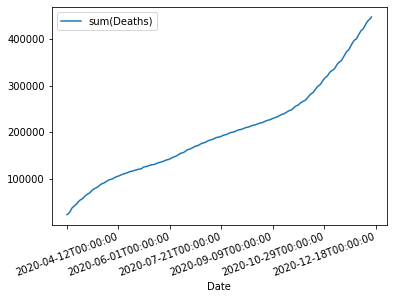

In [10]:
graph_data = pd.read_sql("SELECT sum(Deaths), Date FROM Covid_Data WHERE Date > '2020-04-12' GROUP BY Date;", engine)
graph_data.time = pd.to_datetime(graph_data['Date'], format='%Y-%m-%dT%H:%M:%S')
graph_data.set_index(['Date'], inplace=True)
graph_data.plot(rot=20)